# DNA shape features for k-mer nucleotide mutation rate prediction
## Trees and classification
### Zian Liu
#### Last updated: 7/5/2022

This notebook is run after the main model analysis notebook, and is specifically used for the decision tree models.

## Setup

First, import libraries:

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import seaborn as sns
from joblib import dump, load, Parallel, delayed
from copy import deepcopy
from collections import Counter
from IPython.display import display
from Bio import SeqIO, motifs
from Bio.Seq import Seq
import eli5
from scipy.stats import pearsonr, spearmanr, fisher_exact, binom_test, kstest, percentileofscore, entropy
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.feature_selection import VarianceThreshold, f_regression
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoLarsIC, Lasso, lars_path
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

# Print version info
import Bio
import matplotlib
import joblib
import scipy
import sklearn
print("Numpy version: ", np.__version__, "\nPandas version: ", pd.__version__, "\nMatplotlib version: ", matplotlib.__version__, 
      "\nSeaborn version: ", sns.__version__, "\nScipy version: ", scipy.__version__, "\nScikit-learn version: ", sklearn.__version__, 
      "\nBiopython version: ", Bio.__version__, "\nJoblib version: ", joblib.__version__, "\neli5 version: ", eli5.__version__)

Numpy version:  1.20.3 
Pandas version:  1.3.4 
Matplotlib version:  3.4.3 
Seaborn version:  0.11.2 
Scipy version:  1.7.1 
Scikit-learn version:  0.24.2 
Biopython version:  1.79 
Joblib version:  1.1.0 
eli5 version:  0.11.0


Import functions from file:

In [2]:
from notebook_functions_all import *

Load the files. 

In [3]:
DF_val_join, List_value, Eff_test, Index_class, Index_class_name, Pred_1d, Pred_2d, Minmax_shape, Eff, \
    Labels_2d, Kfoldobj, Pred_2dneibr, Labels_2dneibr, Minmax_2dneibr, Var_red_neibr, \
    Pred_sc_1d, Pred_sc_2d, Labels_sc_2d, Pred_sc_3d, \
    Labels_sc_3d, Pred_sc_4d, Labels_sc_4d, Index_class_sc, \
    Pred_sc_2dneibr, Labels_sc_2dneibr, Pred_sc_3dneibr, Labels_sc_3dneibr, \
    Pred_sc_4dneibr, Labels_sc_4dneibr = load("data_intermediate/import_all_data.joblib")

## Decision tree analysis of shapes

Build simple decision-tree based rules that can identify top/bottom 5% of k-mers: basically, top/bottom 52 or 154 or 205 sequences in each class. 

Start from top/bottom halves first.

Note that we will use only 1st degree shapes to do this, since decision tree includes higher dimension interactions automatically. 

#### Top N% vs bottom N%

Can we compare the top and bottom? Save the decision tree outputs. Since this step will take a while, reload data when completed.

In [4]:
flag_tree_calc_completed = True

if flag_tree_calc_completed:
    # Reload the tree
    Trees_topbottom_out = load("data_out/tree_topbottomN_object.joblib")

else:
    # Build the trees
    Trees_topbottom_out = dict()

    confusion_matrix_concat_all = np.zeros(shape=(18, 0), dtype=int)
    confusion_matrix_concat_all_train = np.zeros(shape=(18, 0), dtype=int)
    for cutoff in [50, 25, 10, 5]:
        Trees_topbottom_out[cutoff] = dict()
        confusion_matrix_concat_train, confusion_matrix_concat_test = np.zeros(shape=(0, 2), dtype=int), np.zeros(shape=(0, 2), dtype=int)
        for select in range(9):
            sort_temp_eff, sort_temp_eff_t = np.argsort(Eff[Index_class==select]), np.argsort(Eff_test[Index_class==select])
            # Training labels
            temp_label = np.zeros(shape=(len(Eff[Index_class==select]), ), dtype=int)
            temp_label[Eff[Index_class==select] <= np.percentile(Eff[Index_class==select], cutoff)] = -1
            temp_label[Eff[Index_class==select] > np.percentile(Eff[Index_class==select], 100-cutoff)] = 1
            # Testing labels
            temp_label_t = np.zeros(shape=(len(Eff_test[Index_class==select]), ), dtype=int)
            temp_label_t[Eff_test[Index_class==select] <= np.percentile(Eff_test[Index_class==select], cutoff)] = -1
            temp_label_t[Eff_test[Index_class==select] > np.percentile(Eff_test[Index_class==select], 100-cutoff)] = 1
            # Cut off middle values
            temp_pred = DF_val_join.iloc[Index_class==select].iloc[temp_label != 0]
            temp_pred_t = DF_val_join.iloc[Index_class==select].iloc[temp_label_t != 0]
            temp_label = temp_label[temp_label != 0]
            temp_label_t = temp_label_t[temp_label_t != 0]
            # Grid search
            model = DecisionTreeClassifier(splitter='best', class_weight='balanced', random_state=42)
            parameters = {'criterion': ['gini'], 'max_depth': [2], 
                         'min_samples_split': [10, 25, 50, 0.1], 'min_samples_leaf': [1, 10, 0.1], 
                         'max_features': ['auto', 'log2', 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, None]}
            obj_gridsearch = GridSearchCV(estimator=model, param_grid=parameters, 
                                          scoring='balanced_accuracy', 
                                          cv=8, return_train_score=True, n_jobs=6)
            obj_gridsearch.fit(temp_pred, temp_label)
            Trees_topbottom_out[cutoff][select] = obj_gridsearch
            # Make predictions
            tmp_out_train = obj_gridsearch.predict(temp_pred)
            tmp_out = obj_gridsearch.predict(temp_pred_t)
            df_train = confusion_matrix(temp_label, tmp_out_train, normalize=None, labels=[-1,1])
            df_test = confusion_matrix(temp_label_t, tmp_out, normalize=None, labels=[-1,1])
            confusion_matrix_concat_train = np.concatenate((confusion_matrix_concat_train, df_train), axis=0)
            confusion_matrix_concat_test = np.concatenate((confusion_matrix_concat_test, df_test), axis=0)
        confusion_matrix_concat_all_train = np.concatenate((confusion_matrix_concat_all_train, confusion_matrix_concat_train), axis=1)
        confusion_matrix_concat_all = np.concatenate((confusion_matrix_concat_all, confusion_matrix_concat_test), axis=1)
    # Formatting
    confusion_matrix_concat_all_train = pd.DataFrame(confusion_matrix_concat_all_train)
    confusion_matrix_concat_all_train.columns = np.array([["pred_low_"+str(N), "pred_high_"+str(N)] for N in [50, 25, 10, 5]]).flatten()
    confusion_matrix_concat_all_train.index = np.array([[select+"_low", select+"_high"] for select in Index_class_name]).flatten()
    confusion_matrix_concat_all = pd.DataFrame(confusion_matrix_concat_all)
    confusion_matrix_concat_all.columns = np.array([["pred_low_"+str(N), "pred_high_"+str(N)] for N in [50, 25, 10, 5]]).flatten()
    confusion_matrix_concat_all.index = np.array([[select+"_low", select+"_high"] for select in Index_class_name]).flatten()

    display(confusion_matrix_concat_all)
    dump(Trees_topbottom_out, "data_out/tree_topbottomN_object.joblib")
    confusion_matrix_concat_all_train.to_csv("data_out/tree_topbottomN_results_train.csv")
    confusion_matrix_concat_all.to_csv("data_out/tree_topbottomN_results.csv")

/home/zianl/anaconda3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/zianl/anaconda3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Visualize the trees via eli5:

In [5]:
dict_tree_expl = dict()
dict_tree_expl[5], dict_tree_expl[10] = dict(), dict()

for select in range(9):
    dict_tree_expl[10][select] = eli5.show_weights(
        Trees_topbottom_out[10][select].best_estimator_, 
        feature_names=list(DF_val_join.columns), target_names=['low', 'high']
    )

for select in range(9):
    dict_tree_expl[5][select] = eli5.show_weights(
        Trees_topbottom_out[5][select].best_estimator_, 
        feature_names=list(DF_val_join.columns), target_names=['low', 'high']
    )

dump(dict_tree_expl, "data_out/tree_interpret_eli5.joblib")

['data_out/tree_interpret_eli5.joblib']

Load results and visualize N=5:

In [6]:
dict_tree_expl = load("data_out/tree_interpret_eli5.joblib")

for select in range(9):
    display(dict_tree_expl[5][select])

Weight,Feature
0.4883,Shear_L_r
0.2972,HelT_R
0.2145,Stagger_L
0,Stagger_C
0,Opening_C
0,Opening_R
0,ProT_L
0,ProT_C
0,ProT_R
0,Shear_L


Weight,Feature
0.8639,Tilt_CR
0.0771,Shear_C_r
0.0590,Opening_L_r
0,Buckle_R
0,Opening_L
0,Opening_C
0,Opening_R
0,ProT_L
0,ProT_C
0,ProT_R


Weight,Feature
0.8674,Roll_CR_r
0.0675,Buckle_R
0.0651,Roll_R
0,Opening_C
0,Opening_R
0,ProT_L
0,ProT_C
0,ProT_R
0,Shear_L
0,Shear_C


Weight,Feature
0.8318,Shift_R
0.0842,Roll_L
0.0841,Buckle_C_r
0,Opening_L
0,Opening_C
0,Opening_R
0,ProT_L
0,ProT_C
0,ProT_R
0,Shear_L


Weight,Feature
0.6934,EP_L_r
0.2526,ProT_L
0.0540,Stagger_L
0,Stagger_C
0,Opening_L
0,Opening_C
0,Opening_R
0,ProT_C
0,ProT_R
0,Shear_L


Weight,Feature
0.6757,Opening_C
0.2279,Shift_CL_r
0.0964,HelT_CL_r
0,Opening_R
0,ProT_L
0,ProT_C
0,ProT_R
0,Shear_L
0,Shear_C
0,MGW_L


Weight,Feature
0.6511,Rise_CL
0.3452,ProT_C
0.0037,Roll_L
0,Stagger_C
0,Opening_C
0,Opening_R
0,ProT_L
0,ProT_R
0,Shear_L
0,Shear_C


Weight,Feature
0.7997,ProT_C
0.2003,HelT_R_r
0,Stretch_C
0,Opening_C
0,Opening_R
0,ProT_L
0,ProT_R
0,Shear_L
0,Shear_C
0,Shear_R


Weight,Feature
0.8909,Slide_L
0.1091,Roll_R
0,Opening_C
0,Opening_R
0,ProT_L
0,ProT_C
0,ProT_R
0,Shear_L
0,Shear_C
0,Stretch_C


Show the ROC curves:

In [7]:
dict_fpr, dict_tpr, dict_fpr_t, dict_tpr_t = dict(), dict(), dict(), dict()
for cutoff in [50, 25, 10, 5]:
    dict_fpr[cutoff], dict_tpr[cutoff], dict_fpr_t[cutoff], dict_tpr_t[cutoff] = dict(), dict(), dict(), dict()
    for select in range(9):
        # Training labels
        temp_label = np.zeros(shape=(len(Eff[Index_class==select]), ), dtype=int)
        temp_label[Eff[Index_class==select] <= np.percentile(Eff[Index_class==select], cutoff)] = -1
        temp_label[Eff[Index_class==select] > np.percentile(Eff[Index_class==select], 100-cutoff)] = 1
        # Testing labels
        temp_label_t = np.zeros(shape=(len(Eff_test[Index_class==select]), ), dtype=int)
        temp_label_t[Eff_test[Index_class==select] <= np.percentile(Eff_test[Index_class==select], cutoff)] = -1
        temp_label_t[Eff_test[Index_class==select] > np.percentile(Eff_test[Index_class==select], 100-cutoff)] = 1
        # Cut off middle values
        temp_pred = DF_val_join.iloc[Index_class==select].iloc[temp_label != 0]
        temp_pred_t = DF_val_join.iloc[Index_class==select].iloc[temp_label_t != 0]
        temp_label = temp_label[temp_label != 0]
        temp_label_t = temp_label_t[temp_label_t != 0]

        # Predict probabilities and fpr/tpr values
        proba_train, proba_test = Trees_topbottom_out[cutoff][select].best_estimator_.predict_proba(temp_pred)[:, 1], \
                                  Trees_topbottom_out[cutoff][select].best_estimator_.predict_proba(temp_pred_t)[:, 1]
        dict_fpr[cutoff][select], dict_tpr[cutoff][select], _ = roc_curve(temp_label, proba_train)
        dict_fpr_t[cutoff][select], dict_tpr_t[cutoff][select], _ = roc_curve(temp_label_t, proba_test)

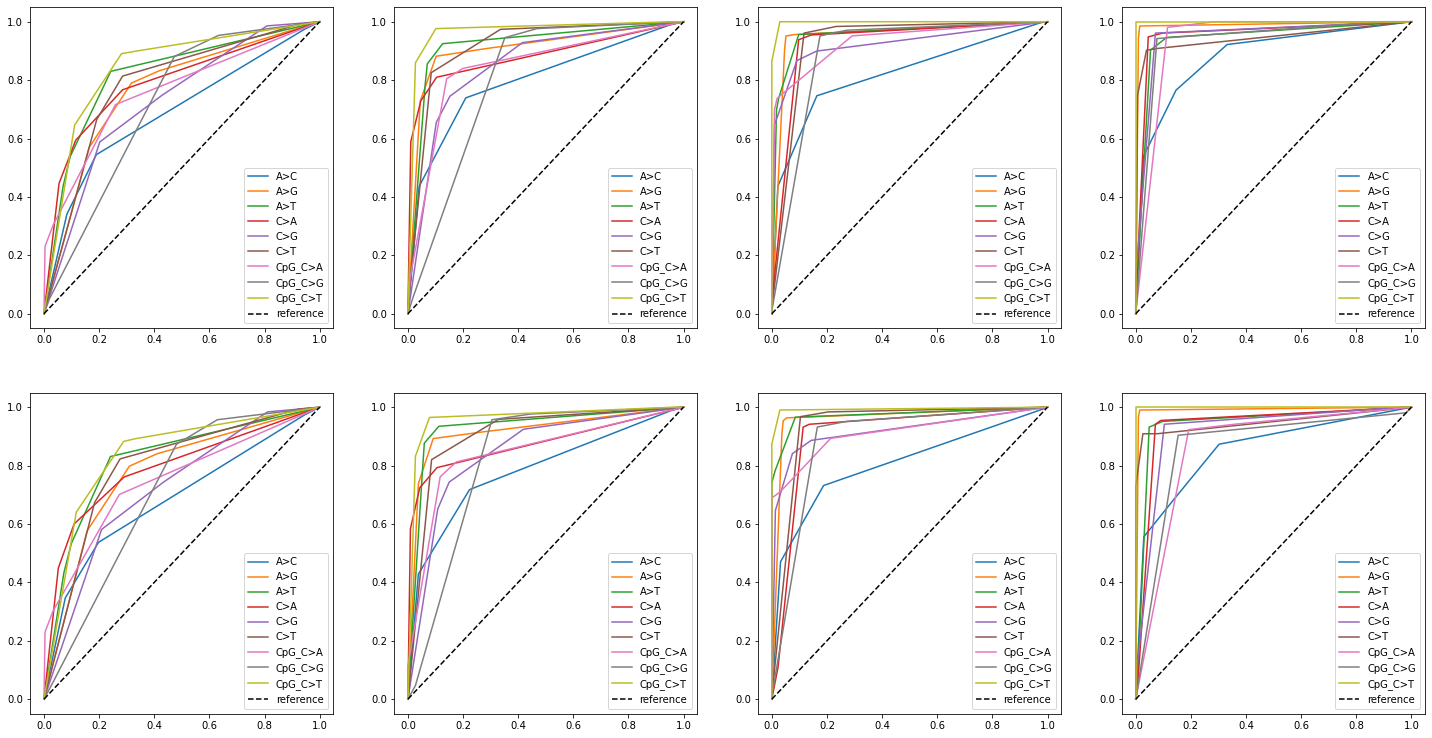

In [8]:
# Figures
fig_out = plt.figure(figsize=[25, 13])
for i in range(4):
    cutoff = [50, 25, 10, 5][i]
    plt.subplot(int(241+i))
    for select in range(9):
        plt.plot(dict_fpr[cutoff][select], dict_tpr[cutoff][select])
    plt.plot([0, 1], [0, 1], color='k', linestyle='--')
    plt.legend(Index_class_name+["reference"])
for i in range(4):
    cutoff = [50, 25, 10, 5][i]
    plt.subplot(int(245+i))
    for select in range(9):
        plt.plot(dict_fpr_t[cutoff][select], dict_tpr_t[cutoff][select])
    plt.plot([0, 1], [0, 1], color='k', linestyle='--')
    plt.legend(Index_class_name+["reference"])
plt.show()
fig_out.savefig("manuscript/figures/pltout_sup_roc.pdf", dpi=300)

Show the AUROC values and bar plot:

In [9]:
array_auroc = np.zeros(shape=(9, 8), dtype=float)
for i in range(4):
    cutoff = [50, 25, 10, 5][i]
    for select in range(9):
        array_auroc[select, [2*i, 2*i+1]] = auc(dict_fpr[cutoff][select], dict_tpr[cutoff][select]), \
                                            auc(dict_fpr_t[cutoff][select], dict_tpr_t[cutoff][select])
DF_auroc = pd.DataFrame(array_auroc)
DF_auroc.index = Index_class_name
DF_auroc.columns = ['50%_train', '50%_test', '25%_train', '25%_test', '10%_train', '10%_test', '5%_train', '5%_test']

display(DF_auroc)
DF_auroc.to_csv("data_out/tree_topbottomN_auroc.csv")

,50%_train,50%_test,25%_train,25%_test,10%_train,10%_test,5%_train,5%_test
A>C,0.689364,0.685379,0.797568,0.783267,0.820708,0.804209,0.883093,0.856883
A>G,0.765757,0.775539,0.908235,0.917933,0.952674,0.961907,0.987662,0.990089
A>T,0.821756,0.820250,0.921587,0.932665,0.955758,0.972293,0.943093,0.947519
C>A,0.790925,0.789683,0.881856,0.874124,0.928076,0.908316,0.957033,0.938860
C>G,0.730229,0.722989,0.852056,0.847818,0.923137,0.917387,0.949717,0.923322
C>T,0.785251,0.795254,0.917503,0.908447,0.930785,0.937964,0.944341,0.948642
CpG_C>A,0.759179,0.746851,0.846786,0.844337,0.931520,0.912527,0.939534,0.866494
CpG_C>G,0.717014,0.708391,0.804871,0.823997,0.894853,0.888774,0.935466,0.867788
CpG_C>T,0.846268,0.838577,0.968246,0.963356,0.998021,0.993308,1.000000,1.000000


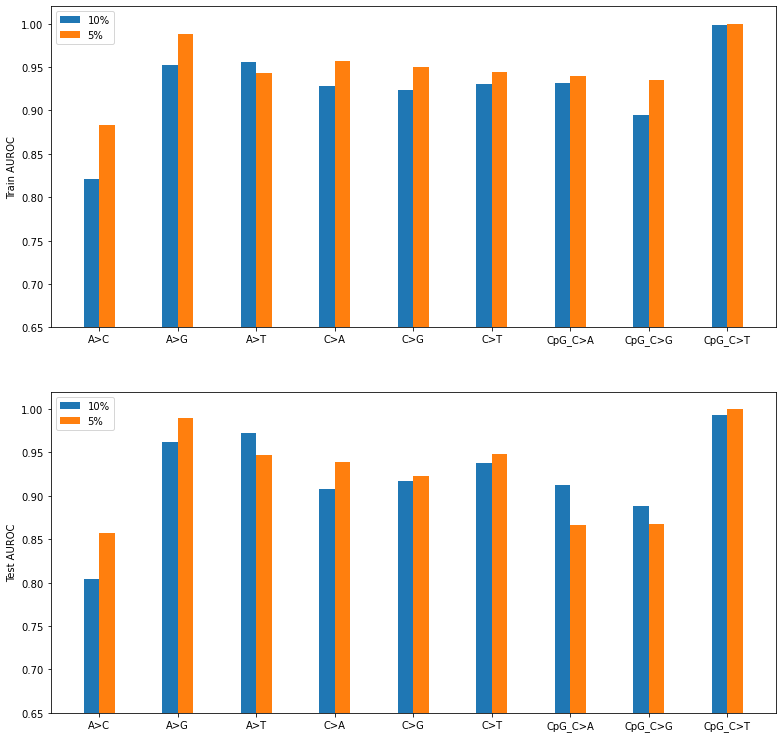

In [10]:
fig_out = plt.figure(figsize=[13, 13])
plt.subplot(211)
for i in [4, 6]:
    plt.bar(np.arange(1, 10) + (i*0.1 - 0.5), DF_auroc.iloc[:, i], width=0.2)
plt.legend(['10%', '5%'])
plt.xticks(np.arange(1, 10), Index_class_name)
plt.ylabel("Train AUROC")
plt.ylim(0.65, 1.02)
plt.subplot(212)
for i in [5, 7]:
    plt.bar(np.arange(1, 10) + (i*0.1 -0.6), DF_auroc.iloc[:, i], width=0.2)
plt.legend(['10%', '5%'])
plt.xticks(np.arange(1, 10), Index_class_name)
plt.ylabel("Test AUROC")
plt.ylim(0.65, 1.02)
plt.show()
fig_out.savefig("manuscript/figures/pltout_fig4a_auroc.pdf", dpi=300)

Count the most important shape features:

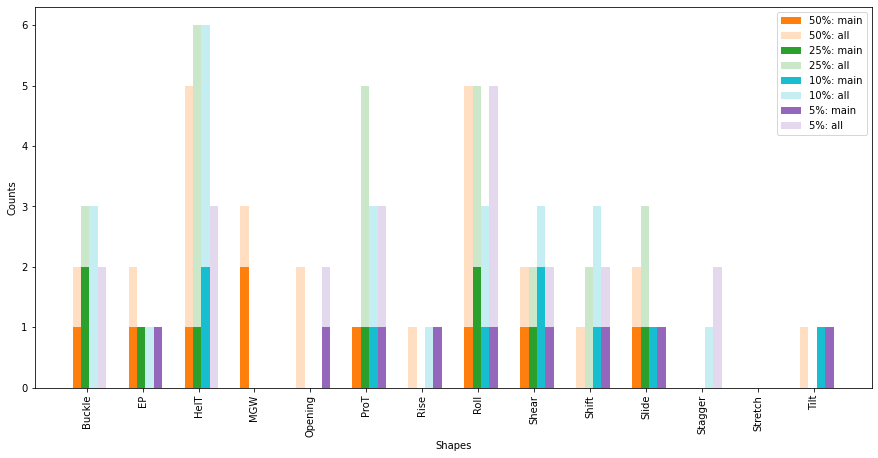

In [11]:
index_shapes = np.array([item.split("_")[0] for item in DF_val_join.columns])

Index_imp_count, Index_imp_count_top = dict(), dict()
for n in [50, 25, 10, 5]:
    Index_important, Index_top = [], []
    for select in range(9):
        temp_index, temp_index_max = index_shapes[Trees_topbottom_out[n][select].best_estimator_.feature_importances_ != 0], \
                                     index_shapes[np.argmax(Trees_topbottom_out[n][select].best_estimator_.feature_importances_)]
        for item in temp_index:
            Index_important.append(item)
        Index_top.append(temp_index_max)
    Index_imp_count[n], Index_imp_count_top[n] = Counter(Index_important), Counter(Index_top)
    Index_imp_count[n] = {key: Index_imp_count[n][key] for key in sorted(set(index_shapes))}
    Index_imp_count_top[n] = {key: Index_imp_count_top[n][key] for key in sorted(set(index_shapes))}
        
fig_out = plt.figure(figsize=[15, 7])
colormap = ['tab:orange', 'tab:green', 'tab:cyan', 'tab:purple']
for i in range(4):
    n = [50, 25, 10, 5][i]
    plt.bar(x=np.arange(1, 15)+(0.15*i-0.375), height=Index_imp_count_top[n].values(), width=0.15, alpha=1, color=colormap[i])
    plt.bar(x=np.arange(1, 15)+(0.15*i-0.375), height=Index_imp_count[n].values(), width=0.15, alpha=0.25, color=colormap[i])
plt.xticks(np.arange(1, 15)-0.2, sorted(set(index_shapes)), rotation=90)
plt.legend(['50%: main', '50%: all', '25%: main', '25%: all', '10%: main', '10%: all', '5%: main', '5%: all'])
plt.ylabel("Counts")
plt.xlabel("Shapes")
plt.show()
#fig_out.savefig("manuscript/figures/pltout_fig4c_treecompar.pdf", dpi=300)

Count the weighed count (use coefficients * counts):

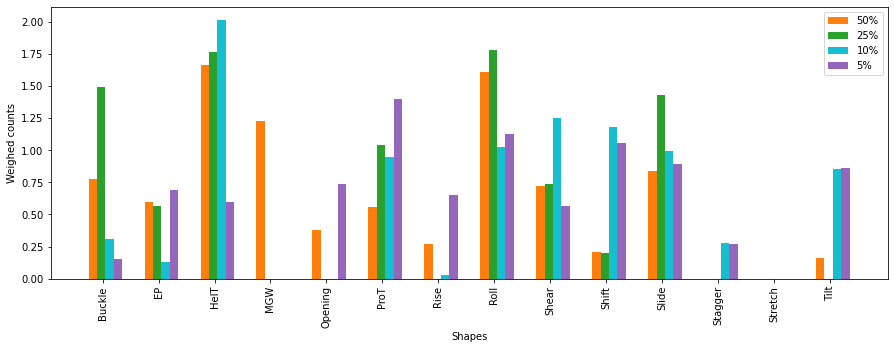

In [12]:
index_shapes = np.array([item.split("_")[0] for item in DF_val_join.columns])

Imp_count_weighed, Imp_count_weighed_byshape = dict(), dict()
for n in [50, 25, 10, 5]:
    Imp_count_weighed[n], Imp_count_weighed_byshape[n] = np.zeros(shape=(len(index_shapes), ), dtype=float), np.zeros(shape=(14, ), dtype=float)
    for select in range(9):
        Imp_count_weighed[n] = Imp_count_weighed[n] + np.array(Trees_topbottom_out[n][select].best_estimator_.feature_importances_)
    for i in range(14):
        item = sorted(set(index_shapes))[i]
        Imp_count_weighed_byshape[n][i] = np.sum(Imp_count_weighed[n][index_shapes == item])
    
fig_out = plt.figure(figsize=[15, 5])
colormap = ['tab:orange', 'tab:green', 'tab:cyan', 'tab:purple']
for i in range(4):
    n = [50, 25, 10, 5][i]
    plt.bar(x=np.arange(1, 15)+(0.15*i-0.375), height=Imp_count_weighed_byshape[n], width=0.15, alpha=1, color=colormap[i])
plt.xticks(np.arange(1, 15)-0.2, sorted(set(index_shapes)), rotation=90)
plt.legend(['50%', '25%', '10%', '5%'])
plt.ylabel("Weighed counts")
plt.xlabel("Shapes")
plt.show()
#fig_out.savefig("manuscript/figures/pltout_fig4d_treecompar_weighed.pdf", dpi=300)

This is good data. Now, show a heatmap of feature weight in each of the mutation classes:

In [13]:
index_shapes = np.array([item.split("_")[0] for item in DF_val_join.columns])

Imp_weighed_byclassshape = dict()
for n in [50, 25, 10, 5]:
    Imp_weighed_byclassshape[n] = np.zeros((14, 9), dtype=float)
    for select in range(9):
        Imp_weighed_byclassshape[n][:, select] = np.array([
            np.sum(np.array(Trees_topbottom_out[n][select].best_estimator_.feature_importances_)[index_shapes == shapetype])
            for shapetype in sorted(set(index_shapes))
        ])
    Imp_weighed_byclassshape[n] = pd.DataFrame(Imp_weighed_byclassshape[n])
    Imp_weighed_byclassshape[n].index = sorted(set(index_shapes))
    Imp_weighed_byclassshape[n].columns = Index_class_name

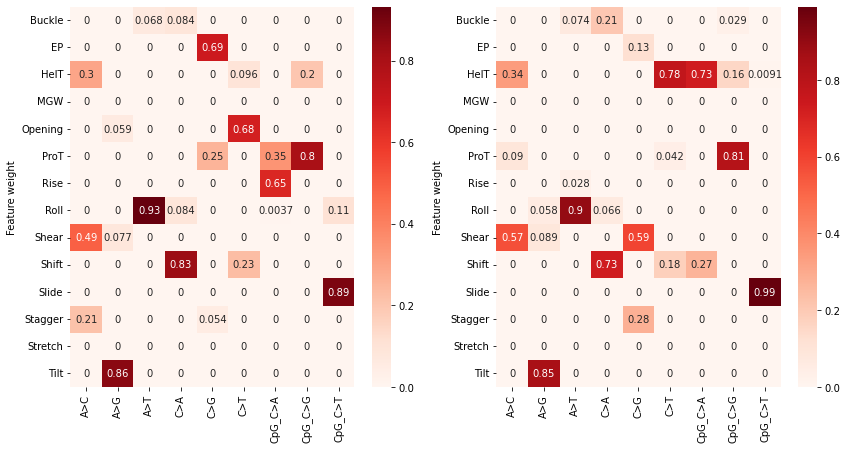

In [14]:
fig_out = plt.figure(figsize=[14, 7])

plt.subplot(121)
sns.heatmap(pd.DataFrame(Imp_weighed_byclassshape[5]), cmap="Reds", annot=True)
plt.ylabel("Feature weight")
plt.yticks(np.arange(0, 14)+0.5, Imp_weighed_byclassshape[5].index, rotation='horizontal')
plt.xticks(np.arange(0, 9)+0.5, Index_class_name, rotation='vertical')

plt.subplot(122)
sns.heatmap(pd.DataFrame(Imp_weighed_byclassshape[10]), cmap="Reds", annot=True)
plt.ylabel("Feature weight")
plt.yticks(np.arange(0, 14)+0.5, Imp_weighed_byclassshape[10].index, rotation='horizontal')
plt.xticks(np.arange(0, 9)+0.5, Index_class_name, rotation='vertical')

plt.show()
#fig_out.savefig("manuscript/figures/pltout_fig4b_treecompar_heatmap.pdf", dpi=300)

Same plot as above, but remove the all-0 rows:

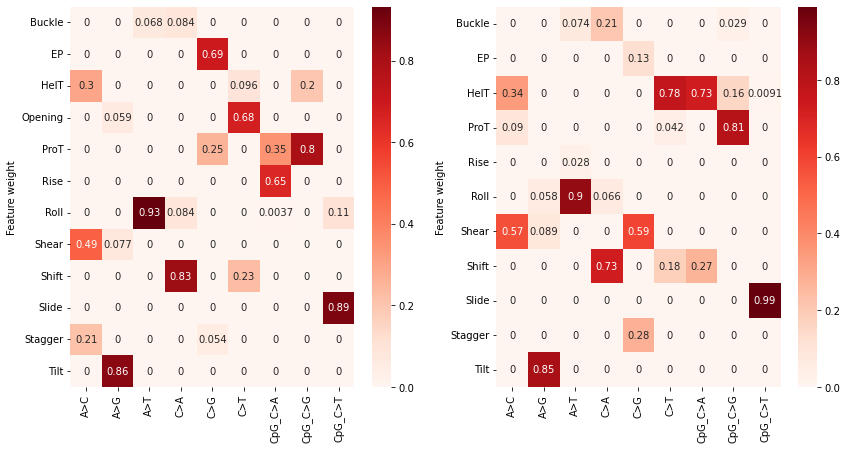

In [15]:
fig_out = plt.figure(figsize=[14, 7])

plt.subplot(121)
temp_df = Imp_weighed_byclassshape[5].loc[Imp_weighed_byclassshape[5].sum(axis=1) != 0]
sns.heatmap(pd.DataFrame(temp_df), cmap="Reds", annot=True)
plt.ylabel("Feature weight")
plt.yticks(np.arange(0, len(temp_df))+0.5, temp_df.index, rotation='horizontal')
plt.xticks(np.arange(0, 9)+0.5, Index_class_name, rotation='vertical')

plt.subplot(122)
temp_df = Imp_weighed_byclassshape[10].loc[Imp_weighed_byclassshape[10].sum(axis=1) != 0]
sns.heatmap(pd.DataFrame(temp_df), cmap="Reds", annot=True)
plt.ylabel("Feature weight")
plt.yticks(np.arange(0, len(temp_df))+0.5, temp_df.index, rotation='horizontal')
plt.xticks(np.arange(0, 9)+0.5, Index_class_name, rotation='vertical')

plt.show()
fig_out.savefig("manuscript/figures/pltout_fig4b_treecompar_heatmap.pdf", dpi=300)

Count the eli5-interpreted shape importance:

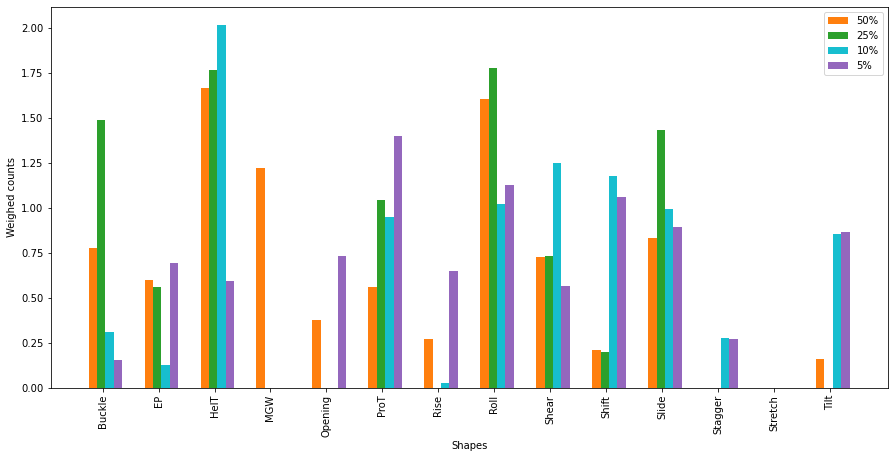

In [16]:
index_shapes = np.array([item.split("_")[0] for item in DF_val_join.columns])

Index_eli5_count = dict()
for n in [50, 25, 10, 5]:
    Index_eli5 = dict(zip(sorted(set(index_shapes)), np.zeros(14, dtype=int)))
    for select in range(9):
        weights_df = eli5.explain_weights_df(
            Trees_topbottom_out[n][select].best_estimator_, 
            feature_names=list(DF_val_join.columns), target_names=['low', 'high']
        )
        temp_index = [item.split('_')[0] for item in weights_df[weights_df['weight'] != 0]['feature']]
        temp_weights = np.array( weights_df[weights_df['weight'] != 0]['weight'] )
        for i in range(len(temp_index)):
            Index_eli5[temp_index[i]] += temp_weights[i]
    Index_eli5_count[n] = Index_eli5

fig_out = plt.figure(figsize=[15, 7])
colormap = ['tab:orange', 'tab:green', 'tab:cyan', 'tab:purple']
for i in range(4):
    n = [50, 25, 10, 5][i]
    plt.bar(x=np.arange(1, 15)+(0.15*i-0.375), height=Index_eli5_count[n].values(), width=0.15, alpha=1, color=colormap[i])
plt.xticks(np.arange(1, 15)-0.2, sorted(set(index_shapes)), rotation=90)
plt.legend(['50%', '25%', '10%', '5%'])
plt.ylabel("Weighed counts")
plt.xlabel("Shapes")
plt.show()

This should be the same as the above plot.

This concludes the classification/decision-tree part of our notebook. Finally, run the TF-binding site analysis.